In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import *
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from nltk.tokenize import sent_tokenize
from konlpy.corpus import kolaw
from konlpy.tag import Okt

Using TensorFlow backend.


In [2]:
'''
seq2seq 동작
1) 입력 문장 -> 인코더 -> 은닉 상태, 셀 상태 얻어냄
2) 상태 정보와 Start 시그널(\t)을 디코더로 전달
3) 다음 문자를 예측 stop 시그널(\n)이 등잘할 때 까지 반복
'''

'\nseq2seq 동작\n1) 입력 문장 -> 인코더 -> 은닉 상태, 셀 상태 얻어냄\n2) 상태 정보와 Start 시그널(\t)을 디코더로 전달\n3) 다음 문자를 예측 stop 시그널(\n)이 등잘할 때 까지 반복\n'

In [3]:
c = kolaw.open('constitution.txt').read()

sent = sent_tokenize(c)  # 357개 문장
temp = sent_tokenize(c)[:5]

okt = Okt()

In [4]:
for i in range(5) :
    for w, t in okt.pos(temp[i]) :
        print('w : ',w)
        print('t : ',t)

w :  대한민국
t :  Noun
w :  헌법
t :  Noun
w :  


t :  Foreign
w :  유구
t :  Noun
w :  한
t :  Josa
w :  역사
t :  Noun
w :  와
t :  Josa
w :  전통
t :  Noun
w :  에
t :  Josa
w :  빛나는
t :  Verb
w :  우리
t :  Noun
w :  대
t :  Modifier
w :  한
t :  Modifier
w :  국민
t :  Noun
w :  은
t :  Josa
w :  3
t :  Number
w :  ·
t :  Punctuation
w :  1
t :  Number
w :  운동
t :  Noun
w :  으로
t :  Josa
w :  건립
t :  Noun
w :  된
t :  Verb
w :  대한민국
t :  Noun
w :  임시정부
t :  Noun
w :  의
t :  Josa
w :  법
t :  Noun
w :  통과
t :  Noun
w :  불의
t :  Noun
w :  에
t :  Josa
w :  항거
t :  Noun
w :  한
t :  Josa
w :  4
t :  Number
w :  ·
t :  Punctuation
w :  19
t :  Number
w :  민주
t :  Noun
w :  이념
t :  Noun
w :  을
t :  Josa
w :  계승
t :  Noun
w :  하고
t :  Josa
w :  ,
t :  Punctuation
w :  조국
t :  Noun
w :  의
t :  Josa
w :  민주
t :  Noun
w :  개혁
t :  Noun
w :  과
t :  Josa
w :  평화
t :  Noun
w :  적
t :  Suffix
w :  통일
t :  Noun
w :  의
t :  Josa
w :  사명
t :  Noun
w :  에
t :  Josa
w :  입
t :  Noun
w :  각하
t :  Noun
w :  여
t :  Josa
w : 

In [5]:
doc0 = [' '.join([w for w,t in okt.pos(s) if t not in ['Number','Foreign'] and w not in ['제', '조']]) for s in sent]
doc0

['대한민국 헌법 유구 한 역사 와 전통 에 빛나는 우리 대 한 국민 은 · 운동 으로 건립 된 대한민국 임시정부 의 법 통과 불의 에 항거 한 · 민주 이념 을 계승 하고 , 조국 의 민주 개혁 과 평화 적 통일 의 사명 에 입 각하 여 정의 · 인도 와 동포 애 로써 민족 의 단결 을 공고 히 하고 , 모든 사회 적 폐습 과 불의 를 타파 하며 , 자율 과 조화 를 바탕 으로 자유민주 적 기 본 질서 를 더욱 확고히 하여 정치 · 경제 · 사회 · 문화 의 모든 영역 에 있어서 각인 의 기회 를 균등히 하고 , 능력 을 최고 도로 발휘 하게 하며 , 자유 와 권리 에 따르는 책임 과 의무 를 완수 하게 하여 , 안 으로는 국민 생활 의 균등한 향상 을 기하 고 밖 으로는 항구 적 인 세계 평화 와 인류 공영 에 이바지 함 으로써 우리 들 과 우리 들 의 자손 의 안전 과 자유 와 행복 을 영원히 확보 할 것 을 다짐 하면서 제정 되고 차 에 걸쳐 개정 된 헌법 을 이제 국회 의 의결 을 거쳐 국민투표 에 의하여 개정 한다 .',
 '장 총 강 대한민국 은 민주공화국 이다 .',
 '대한민국 의 주권 은 국민 에게 있고 , 모든 권력 은 국민 으로부터 나온다 .',
 '대한민국 의 국민 이 되는 요건 은 법률 로 정 한다 .',
 '국가 는 법률 이 정 하는 바 에 의하여 재외국민 을 보호 할 의무 를 진다 .',
 '대한민국 의 영토 는 한반도 와 그 부속 도서 로 한다 .',
 '대한민국 은 통일 을 지향 하며 , 자유민주 적 기 본 질서 에 입각 한 평화 적 통일 정책 을 수립 하고 이를 추진 한 다 .',
 '대한민국 은 국제 평화 의 유지 에 노력 하고 침략 적 전쟁 을 부인 한다 .',
 '국군 은 국가 의 안전보장 과 국토 방위 의 신성한 의무 를 수행 함 을 사명 으로 하며 , 그 정치 적 중립성 은 준수 된다 .',
 '헌법 에 의하여 체결 · 공포 된 조약 과 일반 적 으로 승인 된 국제 법규 는 국내법 과 같은 효력 을 가진다 .',
 '

In [6]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(doc0)
# 문장을 시퀀스로 변환하고, 문장 길이가 2 이상인 문장만 doc에 저장
doc = [tok for tok in tokenizer.texts_to_sequences(doc0) if len(tok) > 1]

print(len(doc))
doc[10]

354


[668, 4, 267, 324, 16, 103, 5, 13, 21, 35, 2, 20, 29, 334, 31, 93, 51]

In [7]:
# 단어 등장 빈도
tokenizer.word_counts

maxLen = max([len(x)-1 for x in doc])
print(maxLen)  # 문장 최대 길이
vocabSize = len(tokenizer.word_index) + 1
print(vocabSize)  # 단어 종류

187
1165


In [8]:
# yield
def cf() :
    for i in range(3) :
        yield i * i
        
obj = cf()
for i in obj :
    print(i)

0
1
4


In [9]:
def genData(doc, maxLen, vocabSize) :
    
    for sent in doc :  # ex> sent의 길이가 7
        inputs = []
        targets = []
        for i in range(1, len(sent)) :  # 1~6
            inputs.append(sent[:i])
            targets.append(sent[i])
            
        # 정답 데이터 원핫인코딩
        y = np_utils.to_categorical(targets, vocabSize)
        # x 데이터 패딩
        inputSeq = sequence.pad_sequences(inputs, maxlen=maxLen, padding='pre')
        
        yield(inputSeq, y)  # 객체가 return

    
    
for i, (x,y) in enumerate(genData(doc, maxLen, vocabSize)) :
    print(i)
    print('x:',x.shape, '\n',x)
    print('y:',y.shape, '\n',y)

0
x: (187, 187) 
 [[  0   0   0 ...   0   0 102]
 [  0   0   0 ...   0 102  28]
 [  0   0   0 ... 102  28 602]
 ...
 [  0   0 102 ... 647 155   2]
 [  0 102  28 ... 155   2  20]
 [102  28 602 ...   2  20 180]]
y: (187, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1
x: (6, 187) 
 [[  0   0   0 ...   0   0  45]
 [  0   0   0 ...   0  45 439]
 [  0   0   0 ...  45 439 648]
 [  0   0   0 ... 439 648 102]
 [  0   0   0 ... 648 102   4]
 [  0   0   0 ... 102   4 649]]
y: (6, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
2
x: (12, 187) 
 [[  0   0   0 ...   0   0 102]
 [  0   0   0 ...   0 102   1]
 [  0   0   0 ... 102   1 440]
 ...
 [  0   0   0 ...  34 651   4]
 [  0   0   0 ... 651   4  22]
 [  0   0   0 ...   4  22 331]]
y: (12, 1165) 
 [[0. 1. 0. ... 0. 0. 0.

34
x: (62, 187) 
 [[  0   0   0 ...   0   0 188]
 [  0   0   0 ...   0 188   1]
 [  0   0   0 ... 188   1 468]
 ...
 [  0   0   0 ... 160  24 348]
 [  0   0   0 ...  24 348  12]
 [  0   0   0 ... 348  12  14]]
y: (62, 1165) 
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
35
x: (29, 187) 
 [[  0   0   0 ...   0   0  34]
 [  0   0   0 ...   0  34  22]
 [  0   0   0 ...  34  22   4]
 ...
 [  0   0   0 ... 110 725 348]
 [  0   0   0 ... 725 348  81]
 [  0   0   0 ... 348  81  41]]
y: (29, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
36
x: (16, 187) 
 [[  0   0   0 ...   0   0  34]
 [  0   0   0 ...   0  34  22]
 [  0   0   0 ...  34  22   4]
 ...
 [  0   0   0 ... 282   3 728]
 [  0   0   0 ...   3 728 350]
 [  0   0   0 ... 728 350  41]]
y: (16, 1165) 
 [[0. 0. 0.

x: (9, 187) 
 [[  0   0   0 ...   0   0 282]
 [  0   0   0 ...   0 282   1]
 [  0   0   0 ... 282   1 360]
 ...
 [  0   0   0 ... 166 284   2]
 [  0   0   0 ... 284   2 750]
 [  0   0   0 ...   2 750  39]]
y: (9, 1165) 
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
57
x: (25, 187) 
 [[  0   0   0 ...   0   0 751]
 [  0   0   0 ...   0 751   2]
 [  0   0   0 ... 751   2 118]
 ...
 [  0   0   0 ... 361 285   3]
 [  0   0   0 ... 285   3 754]
 [  0   0   0 ...   3 754  39]]
y: (25, 1165) 
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
58
x: (12, 187) 
 [[  0   0   0 ...   0   0  34]
 [  0   0   0 ...   0  34  22]
 [  0   0   0 ...  34  22   4]
 ...
 [  0   0   0 ...  35   2  20]
 [  0   0   0 ...   2  20 362]
 [  0   0   0 ...  20 362   3]]
y: (12, 1165) 
 [[0. 0. 0. ... 

x: (7, 187) 
 [[  0   0   0 ...   0   0  34]
 [  0   0   0 ...   0  34  22]
 [  0   0   0 ...  34  22   4]
 ...
 [  0   0   0 ...   4 131   1]
 [  0   0   0 ... 131   1  49]
 [  0   0   0 ...   1  49   8]]
y: (7, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
80
x: (34, 187) 
 [[  0   0   0 ...   0   0  17]
 [  0   0   0 ...   0  17  10]
 [  0   0   0 ...  17  10 136]
 ...
 [  0   0   0 ...  20 793   8]
 [  0   0   0 ... 793   8 119]
 [  0   0   0 ...   8 119  39]]
y: (34, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
81
x: (7, 187) 
 [[  0   0   0 ...   0   0  34]
 [  0   0   0 ...   0  34  22]
 [  0   0   0 ...  34  22   4]
 ...
 [  0   0   0 ...   4 131   1]
 [  0   0   0 ... 131   1  64]
 [  0   0   0 ...   1  64   8]]
y: (7, 1165) 
 [[0. 0. 0. ... 0.

 [[  0   0   0 ...   0   0  45]
 [  0   0   0 ...   0  45  19]
 [  0   0   0 ...  45  19 838]
 ...
 [  0   0   0 ... 838   4  19]
 [  0   0   0 ...   4  19   2]
 [  0   0   0 ...  19   2 236]]
y: (7, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
108
x: (19, 187) 
 [[  0   0   0 ...   0   0  19]
 [  0   0   0 ...   0  19  10]
 [  0   0   0 ...  19  10  22]
 ...
 [  0   0   0 ...  40  68  32]
 [  0   0   0 ...  68  32 145]
 [  0   0   0 ...  32 145  11]]
y: (19, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
109
x: (12, 187) 
 [[  0   0   0 ...   0   0  68]
 [  0   0   0 ...   0  68   1]
 [  0   0   0 ...  68   1  14]
 ...
 [  0   0   0 ...  67 286  47]
 [  0   0   0 ... 286  47  73]
 [  0   0   0 ...  47  73  32]]
y: (12, 1165) 
 [[0. 1. 0. ... 0. 0. 0.]
 

x: (9, 187) 
 [[  0   0   0 ...   0   0 853]
 [  0   0   0 ...   0 853 854]
 [  0   0   0 ... 853 854 855]
 ...
 [  0   0   0 ...  30 856  40]
 [  0   0   0 ... 856  40 154]
 [  0   0   0 ...  40 154  32]]
y: (9, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
125
x: (6, 187) 
 [[  0   0   0 ...   0   0  19]
 [  0   0   0 ...   0  19   1]
 [  0   0   0 ...  19   1  88]
 [  0   0   0 ...   1  88  10]
 [  0   0   0 ...  88  10 168]
 [  0   0   0 ...  10 168  11]]
y: (6, 1165) 
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
126
x: (26, 187) 
 [[  0   0   0 ...   0   0 104]
 [  0   0   0 ...   0 104 100]
 [  0   0   0 ... 104 100  54]
 ...
 [  0   0   0 ... 168 162  41]
 [  0   0   0 ... 162  41  12]
 [  0   0   0 ...  41  12  14]]
y: (26, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]


 [  0   0   0 ...  70   3 150]]
y: (11, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
147
x: (11, 187) 
 [[  0   0   0 ...   0   0 537]
 [  0   0   0 ...   0 537 538]
 [  0   0   0 ... 537 538   1]
 ...
 [  0   0   0 ...  19   1 181]
 [  0   0   0 ...   1 181   3]
 [  0   0   0 ... 181   3 150]]
y: (11, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
148
x: (22, 187) 
 [[  0   0   0 ...   0   0  56]
 [  0   0   0 ...   0  56  10]
 [  0   0   0 ...  56  10 246]
 ...
 [  0   0   0 ...  19   2 148]
 [  0   0   0 ...   2 148  12]
 [  0   0   0 ... 148  12  14]]
y: (22, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
149
x: (25, 187) 
 [[  0   0  

175
x: (30, 187) 
 [[  0   0   0 ...   0   0  89]
 [  0   0   0 ...   0  89  57]
 [  0   0   0 ...  89  57   2]
 ...
 [  0   0   0 ...   8 551 399]
 [  0   0   0 ... 551 399 552]
 [  0   0   0 ... 399 552  24]]
y: (30, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
176
x: (21, 187) 
 [[  0   0   0 ...   0   0  15]
 [  0   0   0 ...   0  15 553]
 [  0   0   0 ...  15 553  31]
 ...
 [  0   0   0 ...  15  32 941]
 [  0   0   0 ...  32 941  80]
 [  0   0   0 ... 941  80  14]]
y: (21, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
177
x: (18, 187) 
 [[  0   0   0 ...   0   0  15]
 [  0   0   0 ...   0  15  32]
 [  0   0   0 ...  15  32  57]
 ...
 [  0   0   0 ... 944 401   2]
 [  0   0   0 ... 401   2 945]
 [  0   0   0 ...   2 945  39]]
y: (18, 1165) 
 [[0. 0.

 [0. 0. 0. ... 0. 0. 0.]]
216
x: (17, 187) 
 [[   0    0    0 ...    0    0   74]
 [   0    0    0 ...    0   74    4]
 [   0    0    0 ...   74    4  151]
 ...
 [   0    0    0 ... 1004  367  151]
 [   0    0    0 ...  367  151    3]
 [   0    0    0 ...  151    3  243]]
y: (17, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
217
x: (11, 187) 
 [[  0   0   0 ...   0   0  62]
 [  0   0   0 ...   0  62  10]
 [  0   0   0 ...  62  10  74]
 ...
 [  0   0   0 ...  15 141 396]
 [  0   0   0 ... 141 396  12]
 [  0   0   0 ... 396  12  14]]
y: (11, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
218
x: (14, 187) 
 [[  0   0   0 ...   0   0 231]
 [  0   0   0 ...   0 231   4]
 [  0   0   0 ... 231   4 566]
 ...
 [  0   0   0 ...  74  32  58]
 [  0   0   0 ...  32  5

y: (35, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
244
x: (8, 187) 
 [[   0    0    0 ...    0    0   17]
 [   0    0    0 ...    0   17  112]
 [   0    0    0 ...   17  112   88]
 ...
 [   0    0    0 ...   10   15    5]
 [   0    0    0 ...   15    5 1026]
 [   0    0    0 ...    5 1026   11]]
y: (8, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
245
x: (15, 187) 
 [[  0   0   0 ...   0   0  17]
 [  0   0   0 ...   0  17 112]
 [  0   0   0 ...  17 112  88]
 ...
 [  0   0   0 ...  46   4   9]
 [  0   0   0 ...   4   9  24]
 [  0   0   0 ...   9  24  13]]
y: (15, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
246
x: (23, 187) 
 [[  0   0

285
x: (13, 187) 
 [[  0   0   0 ...   0   0 290]
 [  0   0   0 ...   0 290   1]
 [  0   0   0 ... 290   1  65]
 ...
 [  0   0   0 ... 206   4   9]
 [  0   0   0 ...   4   9  24]
 [  0   0   0 ...   9  24  13]]
y: (13, 1165) 
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
286
x: (43, 187) 
 [[   0    0    0 ...    0    0  288]
 [   0    0    0 ...    0  288 1059]
 [   0    0    0 ...  288 1059  577]
 ...
 [   0    0    0 ...  169 1061   32]
 [   0    0    0 ... 1061   32   12]
 [   0    0    0 ...   32   12   14]]
y: (43, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
287
x: (8, 187) 
 [[   0    0    0 ...    0    0  104]
 [   0    0    0 ...    0  104 1062]
 [   0    0    0 ...  104 1062    3]
 ...
 [   0    0    0 ...  320   11   72]
 [   0    0    0 ...   11  

 [[  0   0   0 ...   0   0 213]
 [  0   0   0 ...   0 213 255]
 [  0   0   0 ... 213 255  57]
 ...
 [  0   0   0 ...  52 584   8]
 [  0   0   0 ... 584   8  12]
 [  0   0   0 ...   8  12  14]]
y: (26, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
311
x: (11, 187) 
 [[  0   0   0 ...   0   0  89]
 [  0   0   0 ...   0  89 584]
 [  0   0   0 ...  89 584   8]
 ...
 [  0   0   0 ...   4   5   2]
 [  0   0   0 ...   5   2 209]
 [  0   0   0 ...   2 209  39]]
y: (11, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
312
x: (25, 187) 
 [[   0    0    0 ...    0    0 1072]
 [   0    0    0 ...    0 1072    4]
 [   0    0    0 ... 1072    4  213]
 ...
 [   0    0    0 ...  436  328   31]
 [   0    0    0 ...  328   31   93]
 [   0    0    0 ...   31   93  279]]
y: (2

 [0. 0. 0. ... 0. 0. 0.]]
341
x: (20, 187) 
 [[  0   0   0 ...   0   0  28]
 [  0   0   0 ...   0  28 252]
 [  0   0   0 ...  28 252   5]
 ...
 [  0   0   0 ...   4 464  78]
 [  0   0   0 ... 464  78 113]
 [  0   0   0 ...  78 113  39]]
y: (20, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
342
x: (10, 187) 
 [[   0    0    0 ...    0    0 1149]
 [   0    0    0 ...    0 1149  597]
 [   0    0    0 ... 1149  597   28]
 ...
 [   0    0    0 ... 1151    5   28]
 [   0    0    0 ...    5   28    4]
 [   0    0    0 ...   28    4  119]]
y: (10, 1165) 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
343
x: (40, 187) 
 [[  0   0   0 ...   0   0 104]
 [  0   0   0 ...   0 104   5]
 [  0   0   0 ... 104   5  28]
 ...
 [  0   0   0 ... 119 303   2]
 [  0   0   0 ... 303   

In [10]:
# 배열합치기
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8],[9,10]])

# 아래 열로 합쳐짐
np.concatenate((a,b),axis=0)
# 행으로 합쳐짐
np.concatenate((a,b.T),axis=1)
# 1차원으로 합쳐짐
np.concatenate((a,b),axis=None)

xdata = []
ydata = []

for (x,y) in genData(doc, maxLen, vocabSize) :
    xdata.append(x)
    ydata.append(y)
    
xdata = np.concatenate(xdata)
ydata = np.concatenate(ydata)

#     문장 최대 길이, 단어 종류
print(xdata.shape, ydata.shape)

(6917, 187) (6917, 1165)


In [12]:
from keras_tqdm import TQDMNotebookCallback
from keras.models import load_model

In [89]:
# 모델 생성
model = Sequential()

model.add(Embedding(vocabSize, 100, input_length=maxLen))  # 1165,100
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(vocabSize, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# hist = model.fit(xdata, ydata, epochs=470, batch_size=800, verbose=0,callbacks=[TQDMNotebookCallback()])

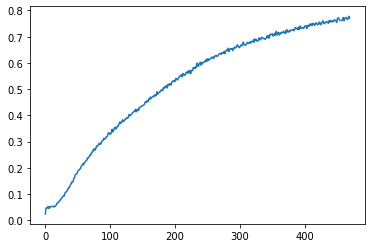

In [94]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.show()
model.save('testGen.hdf5')

In [19]:
# 저장된 모델 불러오기
model = load_model('./testGen.hdf5')

In [28]:
# Test
wordList = '대한민국 의 국민 이 되는 요건 은 법률 로 정한 다 .'.split()
wordList

reverseWordMap = dict(map(reversed, tokenizer.word_index.items()))
len(reverseWordMap)

1164

In [37]:
x = sequence.pad_sequences( [[tokenizer.word_index[w] for w in wordList[:2]]], maxlen=maxLen, padding='pre')
x

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [59]:
pred = np.flip(np.argsort(model.predict(x)))
pred
 
for i in list(pred[0])[:10] :
    print(reverseWordMap[i])

영토
주권
조직
종류
기준
생산
근로
국민
재산권
합동


In [66]:
def predictWord(i, n):
    x=sequence.pad_sequences([[tokenizer.word_index[w] for w in wordList[:i]]], maxlen=maxLen)
    p=model.predict(x)[0]
    idx=np.flip(np.argsort(p),0)
    for j in idx[:n]:
        print(" ".join(wordList[:i]), reverseWordMap[j], "(p={:4.2f}%)".format(100*p[j]))

In [67]:
predictWord(1, 3) #'대한민국' 다음 단어?, 3개 추천
print("="*50)
predictWord(2, 3) #'대한민국 의'다음 단어?, 3개 추천
print("="*50)
predictWord(5, 3) #'대한민국 의 국민 이 되는' 다음 단어?, 3개 추천

대한민국 의 (p=62.48%)
대한민국 은 (p=28.63%)
대한민국 과 (p=1.48%)
대한민국 의 영토 (p=17.69%)
대한민국 의 주권 (p=7.64%)
대한민국 의 조직 (p=2.68%)
대한민국 의 국민 이 되는 요건 (p=94.22%)
대한민국 의 국민 이 되는 국토 (p=0.56%)
대한민국 의 국민 이 되는 및 (p=0.41%)
